# Testing the ReGene framework

## Setup


Import libraries

In [106]:
import importlib
import regene_models
importlib.reload(regene_models)
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

Set the device

In [65]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

In [66]:
print(f"Using device: {device}")

Using device: mps


Load the Datasets

In [67]:
# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

Set the latent dimension

In [92]:
latent_dim = 256

## Classifier

### Training

First we define the classifier

In [93]:
classifier = regene_models.Classifier(latent_dim=latent_dim, num_classes=10, device=device)

Then we train

In [94]:
classifier.train_classifier(trainloader, num_epochs=10, lr=0.001)

Epoch [1/10], Loss: 0.0097
Epoch [2/10], Loss: 0.0007
Epoch [3/10], Loss: 0.0044
Epoch [4/10], Loss: 0.0024
Epoch [5/10], Loss: 0.0013
Epoch [6/10], Loss: 0.0120
Epoch [7/10], Loss: 0.0820
Epoch [8/10], Loss: 0.0080
Epoch [9/10], Loss: 0.0012
Epoch [10/10], Loss: 0.0000


### Testing


First let's test the classifier on a few images

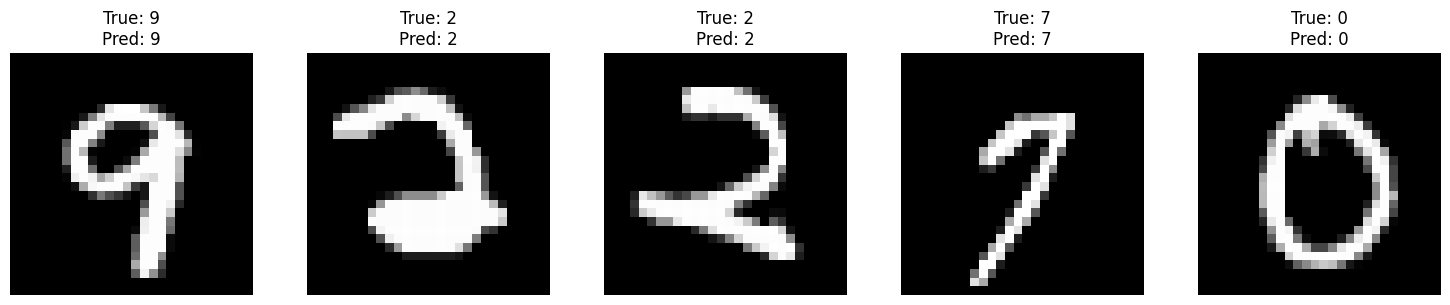

In [95]:
# Get random indices for test images
random_indices = torch.randint(0, len(trainset), (5,))
images = torch.stack([trainset[i][0] for i in random_indices])
labels = torch.tensor([trainset[i][1] for i in random_indices])

# Get predictions
classifier.eval()  # Set to evaluation mode
with torch.no_grad():
    images = images.to(device)
    _, predictions = classifier(images)
    predicted_classes = torch.argmax(predictions, dim=1)

# Plot images with true and predicted labels
plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(images[i].cpu().squeeze().numpy(), cmap='gray')
    plt.title(f'True: {labels[i].item()}\nPred: {predicted_classes[i].cpu().item()}')
    plt.axis('off')

plt.tight_layout()
plt.show()


We'll also visualise the latent space. This is done by taking the latent representations of 50 training images and plotting them in 2D using t-SNE.

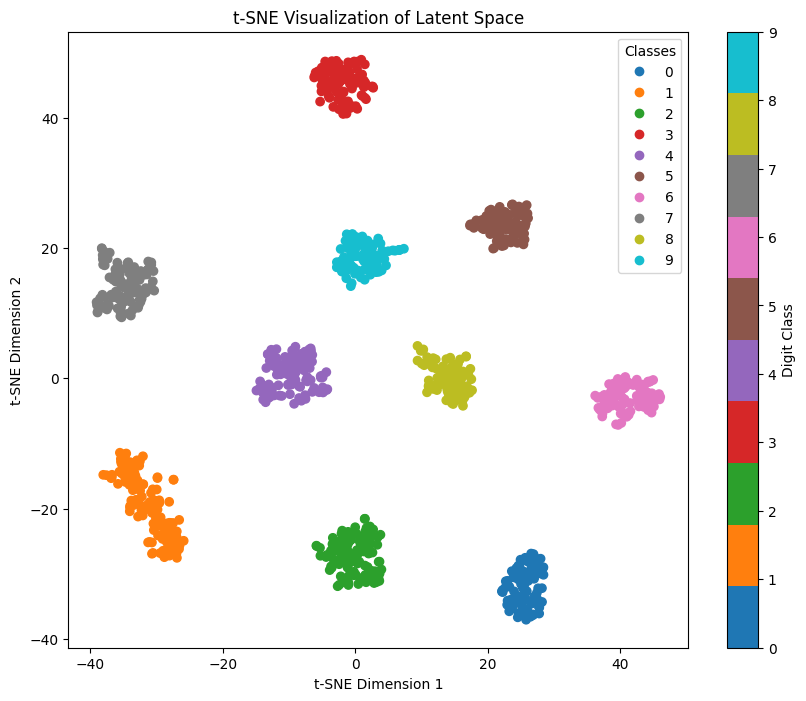

In [96]:
# Get latent representations for 50 random training images
random_indices = torch.randint(0, len(trainset), (1000,))
images = torch.stack([trainset[i][0] for i in random_indices])
labels = torch.tensor([trainset[i][1] for i in random_indices])

# Get latent representations
classifier.eval()
with torch.no_grad():
    images = images.to(device)
    latent_reps, _ = classifier(images)
    latent_reps = latent_reps.cpu().numpy()

# Perform t-SNE dimensionality reduction
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
latent_2d = tsne.fit_transform(latent_reps)

# Plot the 2D latent space
plt.figure(figsize=(10, 8))
scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='tab10')
plt.colorbar(scatter, label='Digit Class')
plt.title('t-SNE Visualization of Latent Space')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(*scatter.legend_elements(), title="Classes")
plt.show()


## Decoder

### Training

We define the decoder, and then train it using the classifier's latent space.

In [99]:
decoder = regene_models.Decoder(latent_dim=latent_dim, device=device)  

In [100]:
decoder.train_decoder(trainloader, classifier, num_epochs=12, lr=0.001)

Decoder Epoch [1/12], Loss: 0.0231
Decoder Epoch [2/12], Loss: 0.0194
Decoder Epoch [3/12], Loss: 0.0202
Decoder Epoch [4/12], Loss: 0.0153
Decoder Epoch [5/12], Loss: 0.0190
Decoder Epoch [6/12], Loss: 0.0187
Decoder Epoch [7/12], Loss: 0.0161
Decoder Epoch [8/12], Loss: 0.0165
Decoder Epoch [9/12], Loss: 0.0170
Decoder Epoch [10/12], Loss: 0.0194
Decoder Epoch [11/12], Loss: 0.0149
Decoder Epoch [12/12], Loss: 0.0129


### Testing


First less visualise some reconstructions

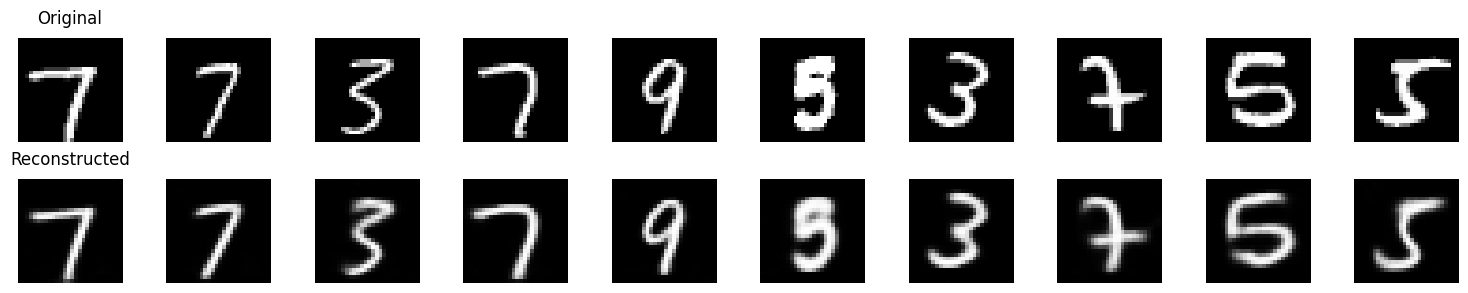

In [104]:
# Get 10 random images from training set
dataiter = iter(trainloader)
images, _ = next(dataiter)
images = images[:10].to(device)

# Get reconstructions
classifier.eval()
decoder.eval()
with torch.no_grad():
    z, _ = classifier(images)
    reconstructed = decoder(z)

# Plot original vs reconstructed images
fig, axes = plt.subplots(2, 10, figsize=(15, 3))
for i in range(10):
    # Original images
    axes[0,i].imshow(images[i].cpu().squeeze(), cmap='gray')
    axes[0,i].axis('off')
    if i == 0:
        axes[0,i].set_title('Original', pad=10)
    
    # Reconstructed images  
    axes[1,i].imshow(reconstructed[i].cpu().squeeze(), cmap='gray')
    axes[1,i].axis('off')
    if i == 0:
        axes[1,i].set_title('Reconstructed', pad=10)

plt.tight_layout()
plt.show()


# Joint training


Let's try training the models with a joint objective

In [110]:
from importlib import reload
import regene_models
importlib.reload(regene_models)
from regene_models import ClassifierGenerator

Alpha determines how much weight is given to the reconstruction loss.

In [111]:
joint_decoder = regene_models.Decoder(latent_dim=256, device=device)
joint_classifier = regene_models.Classifier(latent_dim=latent_dim, num_classes=10, device=device)
regene_models.train_joint(joint_classifier, joint_decoder, trainloader, num_epochs=12, lr=0.001, lambda_recon=0.8)

Epoch [1/12], Total Loss: 0.0225, Classification Loss: 0.0408, Reconstruction Loss: 0.0179
Epoch [2/12], Total Loss: 0.0249, Classification Loss: 0.0779, Reconstruction Loss: 0.0116
Epoch [3/12], Total Loss: 0.0143, Classification Loss: 0.0284, Reconstruction Loss: 0.0108
Epoch [4/12], Total Loss: 0.0199, Classification Loss: 0.0569, Reconstruction Loss: 0.0106
Epoch [5/12], Total Loss: 0.0420, Classification Loss: 0.1637, Reconstruction Loss: 0.0115
Epoch [6/12], Total Loss: 0.0092, Classification Loss: 0.0003, Reconstruction Loss: 0.0114
Epoch [7/12], Total Loss: 0.0069, Classification Loss: 0.0000, Reconstruction Loss: 0.0087
Epoch [8/12], Total Loss: 0.0100, Classification Loss: 0.0063, Reconstruction Loss: 0.0110
Epoch [9/12], Total Loss: 0.0071, Classification Loss: 0.0001, Reconstruction Loss: 0.0088
Epoch [10/12], Total Loss: 0.0083, Classification Loss: 0.0052, Reconstruction Loss: 0.0091
Epoch [11/12], Total Loss: 0.0059, Classification Loss: 0.0000, Reconstruction Loss: 0.00

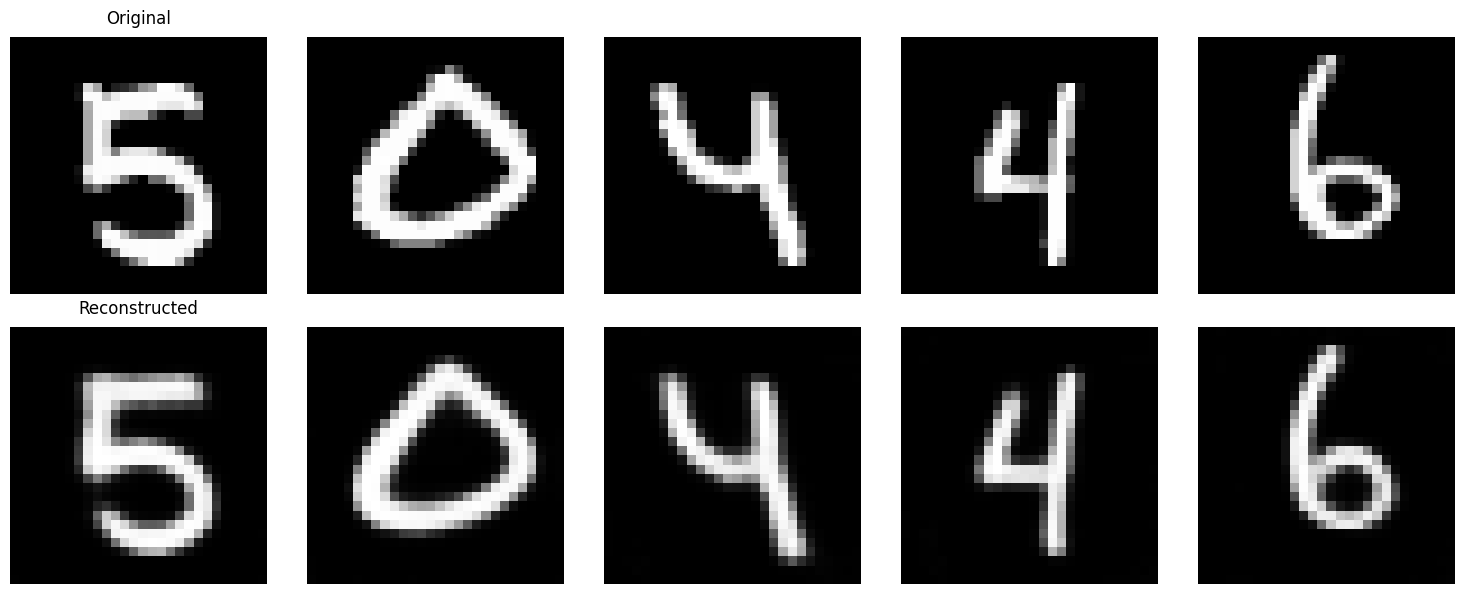

In [114]:
# Get some test images
dataiter = iter(trainloader)
images, labels = next(dataiter)
images = images.to(device)

# Get reconstructions
with torch.no_grad():
    z, _ = joint_classifier(images)
    reconstructed = joint_decoder(z)

# Plot original vs reconstructed images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(5):
    # Original images
    axes[0,i].imshow(images[i].cpu().squeeze(), cmap='gray')
    axes[0,i].axis('off')
    if i == 0:
        axes[0,i].set_title('Original', pad=10)
    
    # Reconstructed images
    axes[1,i].imshow(reconstructed[i].cpu().squeeze(), cmap='gray')
    axes[1,i].axis('off')
    if i == 0:
        axes[1,i].set_title('Reconstructed', pad=10)

plt.tight_layout()
plt.show()


## Training encoder and classifier separately


In this final section, we will train the encoder and classifier separately. The encoder is trained to minimise the reconstruction loss, and the classifier is trained to minimise the cross-entropy loss on the enocders latent space.

In [115]:
from regene_models import train_autoencoder, train_classifier_only

separate_classifier = regene_models.Classifier(latent_dim=latent_dim, num_classes=10, device=device)
separate_decoder = regene_models.Decoder(latent_dim=latent_dim, device=device)

In [116]:
train_autoencoder(classifier=separate_classifier, decoder=separate_decoder, train_loader=trainloader, num_epochs=12, lr=0.001)

Epoch [1/12], Average Reconstruction Loss: 0.0372
Epoch [2/12], Average Reconstruction Loss: 0.0093
Epoch [3/12], Average Reconstruction Loss: 0.0073
Epoch [4/12], Average Reconstruction Loss: 0.0063
Epoch [5/12], Average Reconstruction Loss: 0.0058
Epoch [6/12], Average Reconstruction Loss: 0.0053
Epoch [7/12], Average Reconstruction Loss: 0.0051
Epoch [8/12], Average Reconstruction Loss: 0.0048
Epoch [9/12], Average Reconstruction Loss: 0.0046
Epoch [10/12], Average Reconstruction Loss: 0.0044
Epoch [11/12], Average Reconstruction Loss: 0.0042
Epoch [12/12], Average Reconstruction Loss: 0.0041


In [118]:
train_classifier_only(separate_classifier, trainloader, num_epochs=10, lr=0.001)

## Comparison

We will now compare the performance of the different models.



In [119]:
models = [(classifier, decoder), (joint_classifier, joint_decoder), (separate_classifier, separate_decoder)]

import torch.nn.functional as F
from torchmetrics import Accuracy
import pandas as pd
from IPython.display import display

# Function to calculate metrics
def calculate_metrics(classifier, decoder, test_loader):
    classifier.eval()
    decoder.eval()
    
    total = 0
    correct = 0
    mse_total = 0.0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            # Get predictions and reconstructions
            z, outputs = classifier(images)
            reconstructed = decoder(z)
            
            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Calculate MSE
            mse = F.mse_loss(reconstructed, images)
            mse_total += mse.item()
    
    accuracy = 100 * correct / total
    avg_mse = mse_total / len(test_loader)
    
    return accuracy, avg_mse

# Calculate metrics for each model
model_names = ['Standard', 'Joint Training', 'Separate Training']
results = []

for (clf, dec), name in zip(models, model_names):
    accuracy, mse = calculate_metrics(clf, dec, trainloader)
    results.append({
        'Model': name,
        'Accuracy (%)': f'{accuracy:.2f}',
        'MSE': f'{mse:.4f}'
    })

# Create and display DataFrame
df = pd.DataFrame(results)
display(df)


/Users/conor/Documents/College terms/College/Thesis/Thesis_Code_Minimised/thesis-venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/conor/Documents/College terms/College/Thesis/Thesis_Code_Minimised/thesis-venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,Model,Accuracy (%),MSE
0,Standard,99.86,0.0143
1,Joint Training,99.78,0.0080
2,Separate Training,95.57,0.0040
